In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nfl-playoffs-19702021/df_kaggle_test.csv
/kaggle/input/nfl-playoffs-19702021/playoffs.csv
/kaggle/input/nfl-playoffs-19702021/df_kaggle_test_labels.csv
/kaggle/input/nfl-playoffs-19702021/df_kaggle_train.csv


---

# Experimento 2
Treinando de 1970 ate 2017, testa em 2018

Depois retreina com 2018 e testa 2019.

[...]

In [3]:
from pprint import pprint
from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    accuracy_score,
    balanced_accuracy_score,
    precision_score, 
    recall_score, 
    f1_score
)
from datetime import datetime

all_scores = {}

def show_scores(scores: dict = all_scores):
    display(pd.DataFrame(all_scores.values()))

def calculate_scores(
    model_name: str, 
    y_test: pd.Series, pred: np.ndarray, 
    pos_label: str or int = 1,
    score_list: list = all_scores,
    display_confusion_matrix: bool = True,
    display_scores: bool = True
    ):
    cf_mx = ConfusionMatrixDisplay.from_predictions(y_test, pred)
    acc = accuracy_score(y_test, pred)
    bacc = balanced_accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, pos_label=pos_label)
    recall = recall_score(y_test, pred, pos_label=pos_label)
    f1 = f1_score(y_test, pred, pos_label=pos_label)
    
    model_scores = {
        'model_name': model_name,
        'acc': acc,
        'bacc': bacc,
        'precision': precision,
        'recall': recall,
        'f1score': f1
    }
    score_list[model_name] = model_scores
    
    if display_confusion_matrix:
        display(cf_mx)   
    if show_scores:
        show_scores(score_list)
    return model_scores

In [4]:
from joblib import dump

def save_clf(clf, clf_name: str):
    dump(clf, clf_name + '.joblib')

---

# Carregamento do dataset Kaggle e preparaçao para treino e teste

In [5]:
df_kaggle_train = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_train.csv', sep=';')
df_kaggle_test = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_test.csv', sep=';')
df_kaggle_test_labels = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_test_labels.csv', sep=';')

In [6]:
df_kaggle_train.shape, df_kaggle_test.shape, df_kaggle_test_labels.shape

((526, 263), (52, 262), (52, 2))

In [7]:
all(df_kaggle_test['gs_id'] == df_kaggle_test_labels['gs_id'])

True

---

In [8]:
df_train = df_kaggle_train.sort_values('gs_id', ascending=True).copy()
df_train.set_index('gs_id', inplace=True)

In [9]:
df_test = df_kaggle_test.sort_values('gs_id', ascending=True).copy()
# df_test.loc[:, 'winorlose'] = df_kaggle_test_labels['winorlose']
df_test.set_index('gs_id', inplace=True)

In [10]:
df_test_labels = df_kaggle_test_labels.sort_values('gs_id', ascending=True).copy()
df_test_labels.set_index('gs_id', inplace=True)

df_test_labels = df_test_labels['winorlose'].map({'L': 0, 'W': 1})

In [11]:
df_train.shape, df_test.shape, df_test_labels.shape

((526, 262), (52, 261), (52,))

---

# Pre-processamento

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
encode_target = True
corr_threshold = None
split_data = False
target = 'winorlose'

In [14]:
# bool to numeric
non_numeric_or_object = df_train.select_dtypes(exclude=[np.number, object]).columns
df_train[non_numeric_or_object] = df_train[non_numeric_or_object].astype(int)

non_numeric_or_object = df_test.select_dtypes(exclude=[np.number, object]).columns
df_test[non_numeric_or_object] = df_test[non_numeric_or_object].astype(int)

In [15]:
# cols with values that contain '%' or 'Own' to numeric
for _df in [df_train, df_test]:
    for col in _df.select_dtypes(object).columns:
        if any(_df[col].str.contains('Own', na=False)):
            _df[col] = _df[col].str.extract('[Own]?(\d+.\d*)').astype(float)
            continue
        if any(_df[col].str.contains('%', na=False)):
            _df[col] = _df[col].str.extract('(\d+.\d*)[%]').astype(float)
            continue

In [16]:
# remove columns with values that contain ':' or '-'
for _df in [df_train, df_test]:
    for col in _df.select_dtypes(object).columns:
        if any(_df[col].str.contains(':', na=False)):
            _df.drop(col, axis=1, inplace=True)
            continue
        if any(_df[col].str.contains('-', na=False)):
            _df.drop(col, axis=1, inplace=True)
            continue

In [17]:
# removing additional columns
cols_to_drop = ['gs_game_day_of_week', 'gs_game_date', 'gs_game_location', 'gs_week_number']
for _df in [df_train, df_test]:
        for _col in cols_to_drop:
            try:
                _df.drop(_col, axis=1, inplace=True)
            except KeyError as e:
                print(e)
                continue

In [18]:
# target encoding
target_encoder = {'L': 0, 'W': 1}
df_train[target] = df_train[target].map(target_encoder)

# col names
cat_cols = df_train.select_dtypes(object).columns.tolist()
num_cols = df_train.select_dtypes(np.number).columns.tolist()

In [19]:
# correlation threshold
if bool(corr_threshold) & encode_target:
    _corr = df_train[num_cols].corrwith(df_train[target])
    correlated_cols = _corr[(_corr >= corr_threshold) & (_corr != 1)].index.tolist()
else:
    correlated_cols = num_cols

In [20]:
# x & y
cols_to_use = cat_cols + correlated_cols
#     if 'gs_id' not in cols_to_use:
#         cols_to_use.append('gs_id')

if target in cols_to_use:
    cols_to_use.remove(target)

In [21]:
x_final = df_train.copy().drop(target, axis=1)
x_final = x_final[cols_to_use]
y_final = df_train[target]

df_test = df_test[cols_to_use]

In [22]:
x_final.shape, y_final.shape, df_test.shape, df_test_labels.shape

((526, 254), (526,), (52, 254), (52,))

---

# Separacao dos anos

## Unindo dados de treino de teste

In [23]:
x_train_full = x_final.copy()

x_train_full['winorlose'] = y_final

In [24]:
x_test_full = df_test.copy()

x_test_full['winorlose'] = df_test_labels

In [25]:
x_train_full.shape, x_test_full.shape

df_full = pd.concat([x_train_full, x_test_full])

## Separando anos

In [26]:
x1970_2017 = df_full[df_full['gs_year'] <= 2017].drop('winorlose', axis=1)
y1970_2017 = df_full[df_full['gs_year'] <= 2017]['winorlose']

x2018 = df_full[df_full['gs_year'] == 2018].drop('winorlose', axis=1)
y2018 = df_full[df_full['gs_year'] == 2018]['winorlose']

x2019 = df_full[df_full['gs_year'] == 2019].drop('winorlose', axis=1)
y2019 = df_full[df_full['gs_year'] == 2019]['winorlose']

x2020 = df_full[df_full['gs_year'] == 2020].drop('winorlose', axis=1)
y2020 = df_full[df_full['gs_year'] == 2020]['winorlose']

x2021 = df_full[df_full['gs_year'] == 2021].drop('winorlose', axis=1)
y2021 = df_full[df_full['gs_year'] == 2021]['winorlose']

---

# Pipeline pre-processamento

In [27]:
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

In [28]:
preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)

# Classificadores

In [29]:
RANDOM_STATE = 22

## Gaussian Naive Bayes

In [30]:
from sklearn.naive_bayes import GaussianNB

In [31]:
clf_gaussian_nb = GaussianNB()

## Multi-layer perceptron

In [32]:
from sklearn.neural_network import MLPClassifier

In [33]:
clf_mlp = MLPClassifier(
    max_iter=1000, 
    n_iter_no_change=50, 
    warm_start=True, 
    random_state=RANDOM_STATE
)

## Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
clf_rfc = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='auto',
    max_depth=100,
    bootstrap=False,
    warm_start=True,
    random_state=RANDOM_STATE
)

## Keras

Keras se mostrou muito inconsistente. Para os testes com multiplos classificadores, decidi nao utiliza-lo.

In [36]:
# from keras.models import Sequential
# from keras.layers import Dense, Activation, Flatten
# from keras.wrappers.scikit_learn import KerasClassifier

In [37]:
# def build_keras_model():
#     clf = Sequential()
#     clf.add(Dense(128, input_dim = x_final.shape[1], activation='relu'))

#     clf.add(Dense(256, activation='relu'))
#     clf.add(Dense(256, activation='relu'))
#     clf.add(Dense(256, activation='relu'))

#     clf.add(Dense(1, activation='sigmoid'))

#     clf.compile(
#         loss='binary_crossentropy', 
#         optimizer='adam', 
#         metrics=['accuracy']
#         )
    
#     return clf

In [38]:
# clf_keras = KerasClassifier(build_fn=build_keras_model, epochs=500, batch_size=32, verbose=0)
# clf_keras._estimator_type = "classifier"

# Combinando os classificadores

In [39]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [40]:
def make_new_stacking_pipeline():
    stacking_clf = StackingClassifier(
        estimators=[
            ('gaussian_nb', clf_gaussian_nb),
            ('mlp', clf_mlp),
            # ('keras', clf_keras)
            ('rfc', clf_rfc)
        ],
        final_estimator=LogisticRegression()
    )
    pipeline = make_pipeline(
        preprocess_pipeline,
        RobustScaler(),
        stacking_clf
    )

    return pipeline

## Treino 2010-2019, teste com 2020-2021

In [41]:
x2010_2019 = df_full[(df_full['gs_year'] >= 2010) & df_full['gs_year'] <= 2019].drop('winorlose', axis=1)
y2010_2019 = df_full[(df_full['gs_year'] >= 2010) & df_full['gs_year'] <= 2019]['winorlose']

x2020_2021 = df_full[df_full['gs_year'].isin([2020, 2021])].drop('winorlose', axis=1)
y2020_2021 = df_full[df_full['gs_year'].isin([2020, 2021])]['winorlose']


In [42]:
stack_pipeline = make_new_stacking_pipeline()

In [43]:
stack_pipeline.fit(x2010_2019, y2010_2019)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(fill_value='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f72164d01d0>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector ob...
                ('robustscaler', RobustScaler()),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('gaussian_nb', GaussianNB()),
                                                ('mlp',
                                                 MLPClassifier(max_iter=1000,
  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,acc,bacc,precision,recall,f1score
0,stacking_train_2010-2019,0.535714,0.5,0.0,0.0,0.0


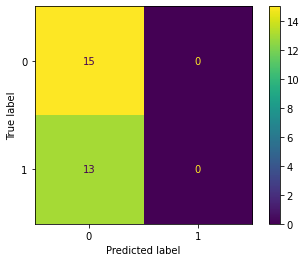

In [44]:
preds_2020_2021 = stack_pipeline.predict(x2020_2021)

scores_2020_2021 = calculate_scores('stacking_train_2010-2019', y2020_2021, preds_2020_2021)

## Treino 2000-2018, teste com 2019-2021

In [45]:
x2000_2018 = df_full[(df_full['gs_year'] >= 2000) & df_full['gs_year'] <= 2018].drop('winorlose', axis=1)
y2000_2018 = df_full[(df_full['gs_year'] >= 2000) & df_full['gs_year'] <= 2018]['winorlose']

x2019_2021 = df_full[df_full['gs_year'].isin([2019, 2020, 2021])].drop('winorlose', axis=1)
y2019_2021 = df_full[df_full['gs_year'].isin([2019, 2020, 2021])]['winorlose']


In [46]:
stack_pipeline = make_new_stacking_pipeline()

In [47]:
stack_pipeline.fit(x2000_2018, y2000_2018)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(fill_value='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f72164d01d0>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector ob...
                ('robustscaler', RobustScaler()),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('gaussian_nb', GaussianNB()),
                                                ('mlp',
                                                 MLPClassifier(max_iter=1000,
  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,acc,bacc,precision,recall,f1score
0,stacking_train_2010-2019,0.535714,0.5,0.0,0.0,0.0
1,stacking_train_2000-2018,0.550000,0.5,0.0,0.0,0.0


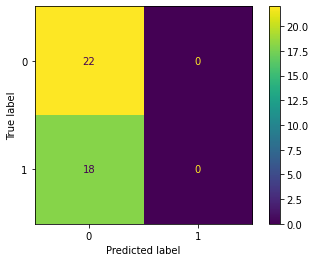

In [48]:
preds_2019_2021 = stack_pipeline.predict(x2019_2021)

scores_2019_2021 = calculate_scores('stacking_train_2000-2018', y2019_2021, preds_2019_2021)